<a href="https://colab.research.google.com/github/michelucci/O2T-Real-Data-Paper/blob/master/notebooks/O2_prediction_model_Network_C_v2_O2T_Paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code related to the paper on the prediction of $[O2]$ and $T$ at the same time with MTL - Network C

## Dataset 1

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import tensorflow as tf

# Keras

from tensorflow.keras.models import Sequential

#from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from tensorflow.keras import Model

from tensorflow.keras import layers
import tensorflow.keras as keras

from keras.utils.vis_utils import plot_model

import tensorflow.keras.backend as K

from numpy import random

from scipy.interpolate import interp1d

from matplotlib.lines import Line2D

import seaborn as sns

Using TensorFlow backend.


# Read the files (Google Drive)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
train_data_df = pd.read_csv('../data/train_data.csv', header = None)
train_target_df = pd.read_csv('../data/train_targets.csv', names=['T', 'O2'], header = None)

# Read the files (Local files)

In [3]:
train_data_df = pd.read_csv('../data/train_data1.csv', header = None)
train_target_df = pd.read_csv('../data/train_targets1.csv', names=['T', 'O2'], header = None)

In [4]:
train_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,-0.026933,-0.040467,-0.053667,-0.067067,-0.080400,-0.093333,-0.106267,-0.119067,-0.131733,-0.162200,...,-0.636400,-0.643267,-0.650067,-0.656533,-0.6628,-0.685600,-0.705667,-0.723333,-0.739133,-0.753067
1,-0.027000,-0.040400,-0.053800,-0.067133,-0.080333,-0.093333,-0.106267,-0.119000,-0.131600,-0.162133,...,-0.636333,-0.643267,-0.650067,-0.656533,-0.6628,-0.685600,-0.705667,-0.723333,-0.739133,-0.753067
2,-0.027000,-0.040467,-0.053667,-0.067133,-0.080333,-0.093333,-0.106200,-0.119000,-0.131667,-0.162200,...,-0.636467,-0.643400,-0.650200,-0.656533,-0.6628,-0.685600,-0.705667,-0.723467,-0.739133,-0.753067
3,-0.027000,-0.040400,-0.053867,-0.067267,-0.080267,-0.093400,-0.106267,-0.119000,-0.131733,-0.162200,...,-0.636467,-0.643400,-0.650200,-0.656667,-0.6628,-0.685600,-0.705667,-0.723333,-0.739133,-0.753067
4,-0.027067,-0.040467,-0.053733,-0.067133,-0.080400,-0.093333,-0.106333,-0.119067,-0.131667,-0.162333,...,-0.636467,-0.643400,-0.650133,-0.656600,-0.6628,-0.685733,-0.705667,-0.723467,-0.739133,-0.753267


In [5]:
train_target_df.head()

,T,O2
0,20.0,35.0
1,20.0,35.0
2,20.0,35.0
3,20.0,35.0
4,20.0,35.0


In [6]:
train_target_df[['O2']] = train_target_df[['O2']]/100.0
train_target_df[['T']] = train_target_df[['T']]/45.0

Note that the values for $T$ are going from 0 to 1. To obtin the actual temperature in Celsius degrees, you need to multiply by $45$.

In [7]:
print(train_target_df['T'].unique())
print(train_target_df['T'].unique()*45)

[0.44444444 0.55555556 0.22222222 0.66666667 0.77777778 0.33333333
 0.88888889 1.         0.11111111]
[20. 25. 10. 30. 35. 15. 40. 45.  5.]


## Dimensions

In [8]:
train_data_df.shape

(3780, 50)

In [9]:
train_target_df[train_target_df['T'] == 5./45.].shape

(420, 2)

To check how many values we have for each temperature we can do easily with ```groupby()```.

In [10]:
train_target_df.groupby('T')['O2'].nunique()

T
0.111111    21
0.222222    21
0.333333    21
0.444444    21
0.555556    21
0.666667    21
0.777778    21
0.888889    21
1.000000    21
Name: O2, dtype: int64

Each of the temperature has 5000 observations.

## Reset the index

In [11]:
train_data_df = train_data_df.reset_index(drop = True);
train_target_df = train_target_df.reset_index(drop = True);

The unique values of the temperature ($T$) are, as expected

In [12]:
np.unique(train_target_df['T'])*45

array([ 5., 10., 15., 20., 25., 30., 35., 40., 45.])

# Frequency values

In [13]:
wred = [  200.,   300.,   400.,   500.,   600.,   700.,   800.,   900.,
        1000.,  1250.,  1500.,  1750.,  2000.,  2250.,  2500.,  2750.,
        3000.,  3250.,  3500.,  3750.,  4000.,  4250.,  4500.,  4750.,
        5000.,  5250.,  5500.,  5750.,  6000.,  6250.,  6500.,  6750.,
        7000.,  7250.,  7500.,  7750.,  8000.,  8250.,  8500.,  8750.,
        9000.,  9250.,  9500.,  9750., 10000., 11000., 12000., 13000.,
       14000., 15000.]

# Dataset split

In [14]:
np.random.seed(42)
rnd = np.random.rand(len(train_target_df)) < 0.8

In [15]:
data_train = train_data_df[rnd]
data_dev = train_data_df[~rnd]
targets_train = train_target_df[rnd]
targets_dev = train_target_df[~rnd]

In [16]:
print('Number of training data observations is ', data_train.shape)
print('Number of dev      data observations is ', data_dev.shape)

Number of training data observations is  (3024, 50)
Number of dev      data observations is  (756, 50)


# Plot 1

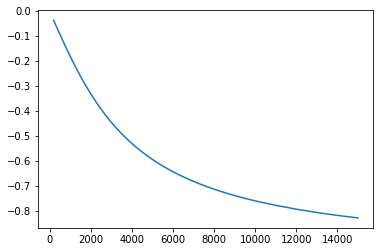

In [17]:
plt.plot(wred, train_data_df.iloc[500])

## Helper Functions

In [18]:
def MAE_T_list_generator(targets_dev, preds_df):
    T_values = targets_dev['T'].unique()*45.0
    MAE_list = []
    MAE_xticks = T_values
    MAE_boxplot = []
    for T_ in T_values:
        elmts = (targets_dev['T'] == T_/45.0)
        tmp_ = targets_dev[elmts]
        tmp2_ = preds_df[elmts]
        mae_ = np.mean(45.0*np.abs(tmp2_['T'].values- tmp_['T'].values))

        MAE_boxplot.append(list(45.0*np.abs(tmp_['T'].values-tmp2_['T'].values)))

        MAE_list.append(mae_)
        
    return MAE_boxplot, MAE_list, MAE_xticks

In [19]:
def MAE_O2_list_generator(step, targets_dev, preds_df):
    breaks = np.arange(step,101.0, step)
    MAE_list = []
    MAE_xticks = []
    MAE_boxplot = []
    for O2_ in breaks:
        elmts = (targets_dev['O2'] < O2_/100.0) & (targets_dev['O2'] >= (O2_-step)/100.0)
        tmp_ = targets_dev[elmts]
        tmp2_ = preds_df[elmts]
        mae_ = np.mean(100*np.abs(tmp2_['O2'].values- tmp_['O2'].values))

        #print ("MAE for range [", int(O2_), ",", int(O2_-step), "] is", mae_)

        MAE_boxplot.append(list(100.0*np.abs(tmp_['O2'].values-tmp2_['O2'].values)))

        MAE_list.append(mae_)
        MAE_xticks.append("["+ str(int(O2_-step))+ ","+ str(int(O2_))+ "]")
    
    return MAE_boxplot, MAE_list, MAE_xticks

In [20]:
# Get predictions
def get_predictions(model, targets_dev, data_dev):
    preds = model.predict(data_dev)
    preds_df = pd.DataFrame(preds)
    preds_df.columns = ['O2', 'T']
    targets_dev_ = targets_dev.reset_index(drop = True)
    preds_df_ = preds_df.reset_index(drop = True)
    
    return targets_dev_, preds_df_

In [21]:
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (epoch % 1000 == 0):
            print ("Just finished epoch", epoch)
            print (logs)
            return
        
class CustomCallbackProgress(keras.callbacks.Callback):
    
    def __init__(self, totalEpochs, step):
        self.step = 0
        self.totalEpochs = totalEpochs
        self.step = step
        
        
    def on_epoch_end(self, epoch, logs={}):
        if (epoch % 200 == 0):
            i = int(epoch / 200)
            
            if (i > 0):
                numberOfEquals = int(self.totalEpochs/200*i)
                percent = 100/(self.totalEpochs/200)*i
            else:
                numberOfEquals = 0
                percent = 0
                
                
            print ("\r[%-20s] %d%%" % ('='*i, percent), end='')
            
            if(percent == 100):
                print('')
        

In [22]:
def reset_keras():
    K.get_session().close()
    K.set_session(tf.Session())
    K.get_session().run(tf.global_variables_initializer())

In [23]:
def average_runs(n_iter, model_):
    MAE_O2_boxplot_avg = [0]*9
    MAE_T_boxplot_avg = [0]*5

    for i in range(n_iter):
        print ("Training iteration ", i)
        
        model_.fit(data_train, targets_train, epochs=4001, batch_size=1000,verbose = 0,
             validation_data= (data_dev, targets_dev), callbacks = [CustomCallbackProgress(4000,200)])

        print("Getting predictions for iteration ",i)
        targets_dev_, preds_df_ = get_predictions(model_, targets_dev, data_dev)
        targets_train_, preds_train_ = get_predictions(model_, targets_train, data_train)

        print("Generating MAE lists for iteration ", i)
        MAE_boxplot_, MAE_list_, MAE_xticks_ = MAE_O2_list_generator(10.0, targets_dev_, preds_df_)
        MAE_T_boxplot_, MAE_T_list_, MAE_T_xticks_ = MAE_T_list_generator(targets_dev_, preds_df_)
        #MAE_boxplot_train_, MAE_list_train_, MAE_xticks_train_ = MAE_list_generator(10.0, targets_train_, preds_train_)

        for j in range(len(MAE_boxplot_)):
            MAE_O2_boxplot_avg[j] = MAE_O2_boxplot_avg[j] + np.array(MAE_boxplot_[j])/n_iter
            
        for j in range(len(MAE_T_boxplot_)):
            MAE_T_boxplot_avg[j] = MAE_T_boxplot_avg[j] + np.array(MAE_T_boxplot_[j])/n_iter

    return MAE_O2_boxplot_avg, MAE_T_boxplot_avg

In [24]:
def get_mae(MAE_boxplot_):
    flat_list = [item for sublist in MAE_boxplot_ for item in sublist]
    return np.mean(flat_list)

# Random Seed to get reproducible results

In [25]:
K.clear_session()

from numpy.random import seed
seed(42)
#from tensorflow import set_random_seed
#set_random_seed(42)

# Network C

In [26]:
class CustomCallback_(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (epoch % 500 == 0):
            print ("Just finished epoch", epoch)
            #print(logs)
            print ("Validation MAE_O2 = ", 100*float(logs.get("val_O2_output_mae")))
            print ("Validation MAE_T = ", 45*float(logs.get("val_T_output_mae")))
            print ("Training   MAE_O2 = ", 100*float(logs.get("O2_output_mae")))
            print ("Training   MAE_T = ", 45*float(logs.get("T_output_mae")))
            
            return

In [27]:
K.clear_session()

In [28]:
input_x = keras.layers.Input(shape = (50,))
lay1 = layers.Dense(50,  activation='sigmoid', dtype = tf.float32)(input_x)
lay2 = layers.Dense(50, activation='sigmoid')(lay1)
lay3 = layers.Dense(50, activation='sigmoid')(lay2)
outboth = layers.Dense(2, activation='sigmoid',name="both_output")(lay3)

lay4 = layers.Dense(5, activation='sigmoid')(lay3)
lay5 = layers.Dense(5, activation='sigmoid')(lay4)
outo2 = layers.Dense(1, activation = 'sigmoid',name="O2_output")(lay5)


lay6 = layers.Dense(5, activation='sigmoid')(lay3)
lay7 = layers.Dense(5, activation='sigmoid')(lay6)
outT = layers.Dense(1, activation = 'sigmoid', name = "T_output")(lay7)

#model = Model(input_x, outl)

model4 = Model(
    inputs=input_x,
    outputs=[outboth, outo2, outT])

In [29]:
model4.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 50)           2550        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 50)           2550        dense[0][0]                      
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 50)           2550        dense_1[0][0]                    
______________________________________________________________________________________________

In [30]:
losses = {
        "both_output": "mse",
        "O2_output": "mse",
        "T_output": "mse"
}

lossWeights = {"both_output": 0.3, "O2_output": 5.0, "T_output": 5.0}

opt = Adam(lr=0.001)

model4.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,
        metrics=["mae"])

In [31]:
targets_train_O2 = targets_train['O2']
targets_dev_O2 = targets_dev['O2']
targets_train_T = targets_train['T']
targets_dev_T = targets_dev['T']

### WORKING HERE

In [32]:
H = model4.fit(data_train,
        {"both_output": targets_train, "O2_output": targets_train_O2, "T_output": targets_train_T},
        validation_data=(data_dev,
            {"both_output": targets_dev, "O2_output": targets_dev_O2, "T_output": targets_dev_T}),
        epochs=20000, batch_size = 19983,
        verbose=0, callbacks = [CustomCallback()])

Just finished epoch 0
{'loss': 1.1701713800430298, 'both_output_loss': 0.10600901, 'O2_output_loss': 0.09249721, 'T_output_loss': 0.13517652, 'both_output_mae': 0.27426845, 'O2_output_mae': 0.26305574, 'T_output_mae': 0.3004994, 'val_loss': 1.2337557077407837, 'val_both_output_loss': 0.10668248, 'val_O2_output_loss': 0.09357973, 'val_T_output_loss': 0.14677045, 'val_both_output_mae': 0.2755413, 'val_O2_output_mae': 0.26497793, 'val_T_output_mae': 0.31478634}
Just finished epoch 1000
{'loss': 0.41742074489593506, 'both_output_loss': 0.039735187, 'O2_output_loss': 0.011343865, 'T_output_loss': 0.06975617, 'both_output_mae': 0.15331058, 'O2_output_mae': 0.08844364, 'T_output_mae': 0.22606322, 'val_loss': 0.43277859687805176, 'val_both_output_loss': 0.04124375, 'val_O2_output_loss': 0.011867769, 'val_T_output_loss': 0.07221332, 'val_both_output_mae': 0.15764557, 'val_O2_output_mae': 0.09129308, 'val_T_output_mae': 0.2313821}
Just finished epoch 2000
{'loss': 0.4042811393737793, 'both_outpu

In [33]:
(O2T, O2, T) = model4.predict(data_dev)
preds_exp_df = pd.DataFrame(O2T)
preds_exp_df.columns = ['O2', 'T']
preds_exp_o2_df = pd.DataFrame(O2[:,0])
preds_exp_o2_df.columns = ['O2']

preds_exp_T_df = pd.DataFrame(T[:,0])
preds_exp_T_df.columns = ['T']

In [34]:
targets_dev = targets_dev.reset_index(drop = True)
preds_exp_o2_df = preds_exp_o2_df.reset_index(drop = True)
preds_exp_T_df = preds_exp_T_df.reset_index(drop = True)

In [35]:
MAE_boxplot_C, MAE_list_C, MAE_xticks_C = MAE_O2_list_generator(10.0, targets_dev, preds_exp_o2_df)
MAET_boxplot_C_MTL, MAET_list_C_MTL, MAET_xticks_C_MTL = MAE_T_list_generator(targets_dev, preds_exp_T_df)

In [36]:
MAE_list_C

[2.1642812951860657,
 3.873238484949282,
 3.431668201802482,
 1.419344337450135,
 1.04603395462036,
 1.5963293852344613,
 3.1598874456004094,
 3.8409026665023625,
 2.3077611706473604,
 2.3188738415880885]

In [37]:
np.mean(MAE_list_C) 
# 64/32/32 -->
# 50       -->
# 80       -->

2.515832078358101

<Figure size 432x288 with 0 Axes>

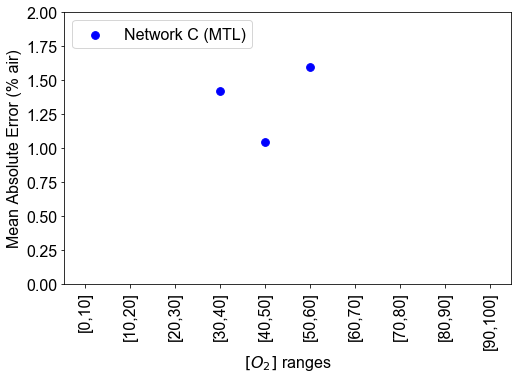

In [38]:
maxx = 4.0

plt.rc('font', family='arial')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
    
plt.tight_layout()

fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(1, 1, 1)

#bp = ax.scatter(range(1,len(MAE_xticks50)+1),MAE_list50, s = 60, color = 'black', label = 'Network A (50/50/50)')
#bp = ax.scatter(range(1,len(MAE_xticks_MTL)+1),MAE_list_MTL, s = 60, color = 'red', label = 'Network B (MTL)')
bp = ax.scatter(range(1,len(MAE_xticks_C)+1),MAE_list_C, s = 60, color = 'blue', label = 'Network C (MTL)')
plt.ylim(0, 2)
plt.xticks(range(1,len(MAE_xticks_C)+1), MAE_xticks_C, size='small', rotation = 'vertical')
#plt.grid()
plt.ylabel('Mean Absolute Error (% air)', fontsize = 16)
plt.xlabel('$[O_2]$ ranges', fontsize = 16)
plt.tick_params(labelsize=16)
plt.legend(loc = 'upper left', fontsize = 16)
#plt.xlim(0,9.5)


#fig.savefig('Figures/absolute_error_for_T_boxplots.eps', format='eps', dpi=300,bbox_inches='tight')

(-0.1, 45)

<Figure size 432x288 with 0 Axes>

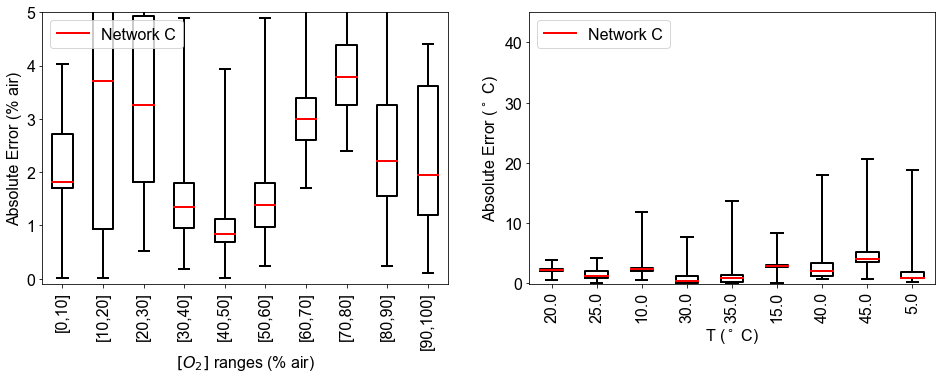

In [39]:
maxy = 5.0


plt.rc('font', family='arial')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
    
plt.tight_layout()

fig = plt.figure(figsize=(16, 5))



ax = fig.add_subplot(1, 2, 1)


bp = ax.boxplot(MAE_boxplot_C, whis = 'range')
ax.set_xticklabels([5, 15, 25, 35, 45])

for whisker in bp['whiskers']:
    whisker.set(color = 'black', linewidth = 2)
for cap in bp['caps']:
    cap.set(color = 'black', linewidth = 2)
for box in bp['boxes']:
    box.set(color = 'black', linewidth = 2)
for median in bp['medians']:
    median.set(color = 'red', linewidth = 2)
for outl in bp['fliers']:
    outl.set(linewidth = 0, ms = 0, mew = 1.4, markerfacecolor = 'none')
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)

legend_elements = [
                  Line2D([0], [0],  lw = 2, color='red', label='Network C',
                          markerfacecolor='none', markeredgewidth=1.4, markersize=8)]
ax.legend(handles=legend_elements, loc='upper left', fontsize = 16)

plt.xticks(range(1,len(MAE_xticks_C)+1), MAE_xticks_C, size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Absolute Error (% air)', fontsize = 16)
plt.xlabel('$[O_2]$ ranges (% air)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(-0.1,maxy)




ax = fig.add_subplot(1, 2, 2)


bp = ax.boxplot(MAET_boxplot_C_MTL, whis = 'range')
ax.set_xticklabels([5, 15, 25, 35, 45])

for whisker in bp['whiskers']:
    whisker.set(color = 'black', linewidth = 2)
for cap in bp['caps']:
    cap.set(color = 'black', linewidth = 2)
for box in bp['boxes']:
    box.set(color = 'black', linewidth = 2)
for median in bp['medians']:
    median.set(color = 'red', linewidth = 2)
for outl in bp['fliers']:
    outl.set(linewidth = 0, ms = 0, mew = 1.4, markerfacecolor = 'none')
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)

legend_elements = [
                  Line2D([0], [0],  lw = 2, color='red', label='Network C',
                          markerfacecolor='none', markeredgewidth=1.4, markersize=8)]
ax.legend(handles=legend_elements, loc='upper left', fontsize = 16)

plt.xticks(range(1,len(MAET_xticks_C_MTL)+1), MAET_xticks_C_MTL, size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Absolute Error ($^\circ$ C)', fontsize = 16)
plt.xlabel('T ($^\circ$ C)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(-0.1,45)


In [ ]:
pdo2 = pd.DataFrame({'MAE_list': MAE_list_C, 'MAE_xticks': MAE_xticks_C, 'MAE_boxplot': MAE_boxplot_C})
pdT = pd.DataFrame({'MAET_list': MAET_list_C_MTL,'MAET_boxplot': MAET_boxplot_C_MTL, 'MAET_xticks':MAET_xticks_C_MTL})
pdo2.to_csv('/content/gdrive/My Drive/data/netc_O2.csv')
pdT.to_csv('/content/gdrive/My Drive/data/netc_T.csv')

In [98]:
np.mean(MAE_list_C)

0.24199813485661367

In [99]:
np.mean(MAET_list_C_MTL)

1.6562986021164623

In [100]:
MAE_boxplot_C_flat = [item for sublist in MAE_boxplot_C for item in sublist]
MAET_boxplot_C_MTL_flat = [item for sublist in MAET_boxplot_C_MTL for item in sublist]
#type(MAE_boxplot_C)

<Figure size 432x288 with 0 Axes>

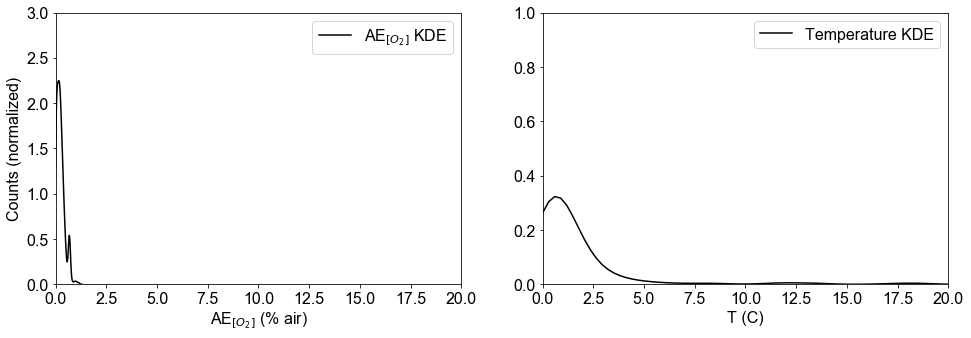

In [105]:

    
plt.tight_layout()

fig = plt.figure(figsize=(16, 5))



ax = fig.add_subplot(1, 2, 1)


sns.distplot(MAE_boxplot_C_flat, color = 'black', hist = False, label = 'AE$_{[O_2]}$ KDE')


ax.legend( fontsize = 16)

#plt.xticks(range(1,len(neta50_O2['MAE_xticks'])+1), neta50_O2['MAE_xticks'], size='small', rotation = 'vertical')

#plt.grid()

plt.ylabel('Counts (normalized)', fontsize = 16)
plt.xlabel('AE$_{[O_2]}$ (% air)', fontsize = 16)
plt.tick_params(labelsize=16)
plt.ylim(0, 3)
plt.xlim(0, 20)


ax = fig.add_subplot(1, 2,2)
# MAE_boxplot_C, MAE_list_C, MAE_xticks_C
sns.distplot(MAET_boxplot_C_MTL_flat,  color = 'black', hist = False, label = 'Temperature KDE')
    
#plt.ylim(-0.2, 2.9)
    
#ax.text(1, 1.5, 'Value for $[O_2] = 100$ % Air', fontsize = 18)

plt.xlabel('T (C)', fontsize = 16)
plt.tick_params(labelsize=16)
ax.legend( fontsize = 16)
plt.ylim(0, 1.0)
plt.xlim(0, 20)




plt.show()

#fig.savefig('/content/gdrive/My Drive/plot3.eps', format='eps', dpi=300,bbox_inches='tight')



#fig.savefig('Figures/absolute_error_for_T_boxplots.eps', format='eps', dpi=300,bbox_inches='tight')

# VERSIONS

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

print(tf.VERSION)
print(tf.keras.__version__)

In [ ]:
p